# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

import steves_utils.wisig.utils as wisig


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.00001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["datasets"] = [
    {
        "labels": list(set(ALL_NODES)-set(ALL_NODES_MINIMUM_1000_EXAMPLES)),
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source", # Fill in later
        "x_transforms": ["jitter_256_10", "lowpass_+/-10MHz", "take_200"],
        "episode_transforms": [],
        "domain_prefix": "C_A_"
    },
    {
        "labels": ALL_NODES_MINIMUM_1000_EXAMPLES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 1000,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source", # Fill in later
        "x_transforms": ["jitter_256_10", "lowpass_+/-10MHz", "take_200"],
        "episode_transforms": [],
        "domain_prefix": "C_B_"
    },
    {
        "labels": list(set(wisig.ALL_NODES_MINIMUM_100_EXAMPLES) - set(wisig.ALL_NODES_MINIMUM_500_EXAMPLES + wisig.ALL_NODES_MINIMUM_1000_EXAMPLES)),
        "domains": wisig.ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source", # Fill in later
        "x_transforms": ["jitter_256_10", "lowpass_+/-10MHz", "take_200"],
        "episode_transforms": [],
        "domain_prefix": "W_A_"
    },
    {
        "labels": list(set(wisig.ALL_NODES_MINIMUM_500_EXAMPLES) - set(wisig.ALL_NODES_MINIMUM_1000_EXAMPLES)),
        "domains": wisig.ALL_DAYS,
        "num_examples_per_domain_per_label": 500,
        "pickle_path": os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source", # Fill in later
        "x_transforms": ["jitter_256_10", "lowpass_+/-10MHz", "take_200"],
        "episode_transforms": [],
        "domain_prefix": "W_B_"
    },
    {
        "labels": wisig.ALL_NODES_MINIMUM_1000_EXAMPLES,
        "domains": wisig.ALL_DAYS,
        "num_examples_per_domain_per_label": 1000,
        "pickle_path": os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source", # Fill in later
        "x_transforms": ["jitter_256_10", "lowpass_+/-10MHz", "take_200"],
        "episode_transforms": [],
        "domain_prefix": "W_C_"
    },
#     {
#         "labels": ALL_SERIAL_NUMBERS,
#         "domains": ALL_DISTANCES_FEET_NARROWED[:1],
#         "num_examples_per_domain_per_label": 500,
#         "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#         "source_or_target_dataset": "source", # Fill in later
#         "x_transforms": ["jitter_256_10", "take_200", "resample_20Msps_to_25Msps"],
#         "episode_transforms": [],
#         "domain_prefix": "O_2_"
#     },
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 2000,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target", # Fill in later
        "x_transforms": ["jitter_256_10", "take_200", "resample_20Msps_to_25Msps"],
        "episode_transforms": [],
        "domain_prefix": "O_1_"
    }
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":[1,7], "bias":False, "padding":[0,3], },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":[2,7], "bias":True, "padding":[0,3], },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Set this to True if you want to run this template directly
STANDALONE = True
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



parameters not injected, running with standalone_parameters


In [5]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [6]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [7]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [8]:
start_time_secs = time.time()

In [9]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [10]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [11]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [12]:
for ds in p.datasets:
    add_dataset(**ds)

In [13]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [14]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)
print(s_x.shape)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'C_A_2', 'W_C_4', 'W_B_4', 'W_A_4', 'W_A_2', 'W_C_3', 'C_A_5', 'C_A_3', 'W_C_2', 'W_B_2', 'C_A_1', 'C_B_2', 'C_B_5', 'W_B_3', 'C_B_4', 'C_B_1', 'C_B_3', 'W_A_1', 'C_A_4', 'W_A_3', 'W_B_1', 'W_C_1'}
{'O_1_44', 'O_1_38', 'O_1_32', 'O_1_26', 'O_1_14', 'O_1_50', 'O_1_8', 'O_1_20'}
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([24, 2, 256])


In [15]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [16]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 4529], examples_per_second: 40.1270, train_label_loss: 1.9467, 
epoch: 1, [batch: 453 / 4529], examples_per_second: 2578.8970, train_label_loss: 0.6570, 
epoch: 1, [batch: 906 / 4529], examples_per_second: 2638.8984, train_label_loss: 0.7708, 
epoch: 1, [batch: 1359 / 4529], examples_per_second: 2659.7528, train_label_loss: 0.2641, 
epoch: 1, [batch: 1812 / 4529], examples_per_second: 2601.8548, train_label_loss: 0.4073, 
epoch: 1, [batch: 2265 / 4529], examples_per_second: 2541.0710, train_label_loss: 0.6068, 
epoch: 1, [batch: 2717 / 4529], examples_per_second: 2521.9456, train_label_loss: 0.0510, 
epoch: 1, [batch: 3170 / 4529], examples_per_second: 2640.9281, train_label_loss: 0.0847, 
epoch: 1, [batch: 3623 / 4529], examples_per_second: 2660.1734, train_label_loss: 0.0293, 
epoch: 1, [batch: 4076 / 4529], examples_per_second: 2644.1257, train_label_loss: 0.0717, 
epoch: 1, source_val_acc_label: 0.9002, target_val_acc_label: 0.3735, source_val_label_loss: 2.67

epoch: 8, [batch: 453 / 4526], examples_per_second: 2629.1608, train_label_loss: 0.0001, 
epoch: 8, [batch: 906 / 4526], examples_per_second: 2651.4375, train_label_loss: 0.0080, 
epoch: 8, [batch: 1358 / 4526], examples_per_second: 2667.0450, train_label_loss: 0.0005, 
epoch: 8, [batch: 1811 / 4526], examples_per_second: 2646.3001, train_label_loss: 0.0013, 
epoch: 8, [batch: 2263 / 4526], examples_per_second: 2652.3274, train_label_loss: 1.2982, 
epoch: 8, [batch: 2716 / 4526], examples_per_second: 2641.4813, train_label_loss: 0.1317, 
epoch: 8, [batch: 3168 / 4526], examples_per_second: 2672.8796, train_label_loss: 0.0022, 
epoch: 8, [batch: 3621 / 4526], examples_per_second: 2681.0176, train_label_loss: 0.0004, 
epoch: 8, [batch: 4073 / 4526], examples_per_second: 2638.2325, train_label_loss: 0.0037, 
epoch: 8, source_val_acc_label: 0.9785, target_val_acc_label: 0.5151, source_val_label_loss: 0.0824, target_val_label_loss: 1.7624, 
epoch: 9, [batch: 1 / 4529], examples_per_second: 

epoch: 15, [batch: 453 / 4528], examples_per_second: 2648.8189, train_label_loss: 0.0033, 
epoch: 15, [batch: 906 / 4528], examples_per_second: 2662.8674, train_label_loss: 0.0432, 
epoch: 15, [batch: 1359 / 4528], examples_per_second: 2688.6848, train_label_loss: 0.0226, 
epoch: 15, [batch: 1811 / 4528], examples_per_second: 2661.0096, train_label_loss: 0.0854, 
epoch: 15, [batch: 2264 / 4528], examples_per_second: 2691.0105, train_label_loss: 0.0017, 
epoch: 15, [batch: 2717 / 4528], examples_per_second: 2651.0211, train_label_loss: 0.0008, 
epoch: 15, [batch: 3169 / 4528], examples_per_second: 2695.5689, train_label_loss: 0.0002, 
epoch: 15, [batch: 3622 / 4528], examples_per_second: 2670.4762, train_label_loss: 0.0001, 
epoch: 15, [batch: 4075 / 4528], examples_per_second: 2700.8842, train_label_loss: 0.0001, 
epoch: 15, source_val_acc_label: 0.9823, target_val_acc_label: 0.5805, source_val_label_loss: 0.0664, target_val_label_loss: 1.7149, 
epoch: 16, [batch: 1 / 4524], examples_p

epoch: 22, [batch: 906 / 4529], examples_per_second: 2678.3919, train_label_loss: 0.0049, 
epoch: 22, [batch: 1359 / 4529], examples_per_second: 2698.0827, train_label_loss: 0.2369, 
epoch: 22, [batch: 1812 / 4529], examples_per_second: 2672.2996, train_label_loss: 0.0002, 
epoch: 22, [batch: 2265 / 4529], examples_per_second: 2704.0405, train_label_loss: 0.0008, 
epoch: 22, [batch: 2717 / 4529], examples_per_second: 2668.7380, train_label_loss: 0.0003, 
epoch: 22, [batch: 3170 / 4529], examples_per_second: 2701.8930, train_label_loss: 0.0871, 
epoch: 22, [batch: 3623 / 4529], examples_per_second: 2677.9618, train_label_loss: 0.0017, 
epoch: 22, [batch: 4076 / 4529], examples_per_second: 2698.8125, train_label_loss: 0.0000, 
epoch: 22, source_val_acc_label: 0.9851, target_val_acc_label: 0.5154, source_val_label_loss: 0.0546, target_val_label_loss: 1.6389, 
epoch: 23, [batch: 1 / 4527], examples_per_second: 3.0133, train_label_loss: 0.0039, 
epoch: 23, [batch: 453 / 4527], examples_per_

In [17]:
total_experiment_time_secs = time.time() - start_time_secs

In [18]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

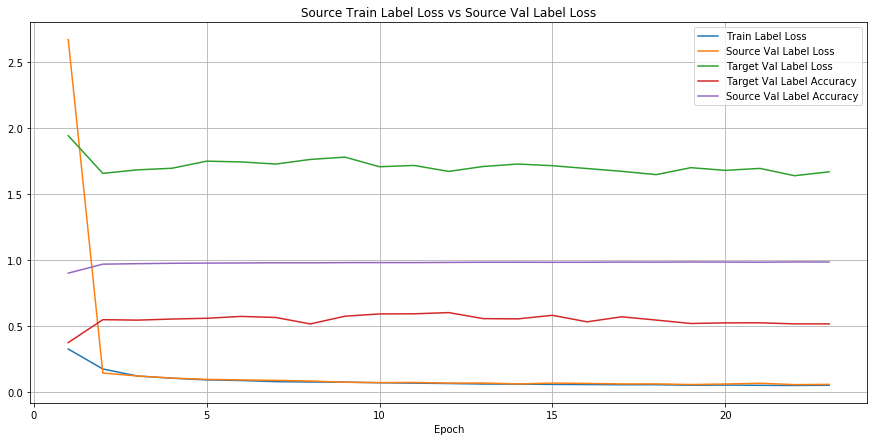

In [19]:
ax = get_loss_curve(experiment)
plt.show()

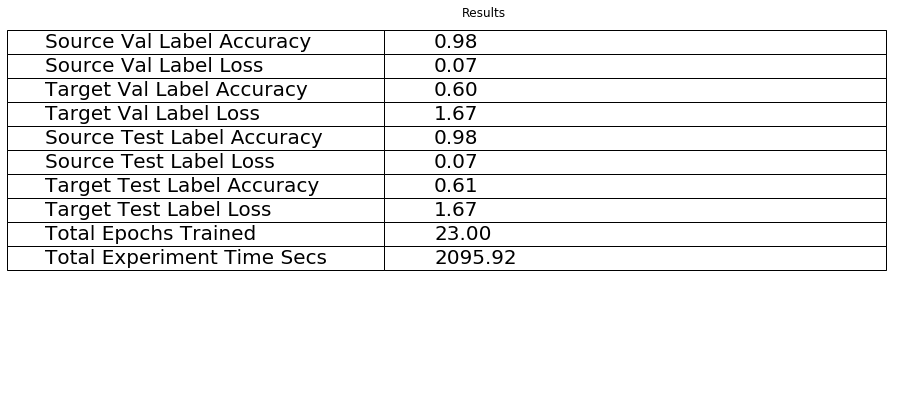

In [20]:
get_results_table(experiment)

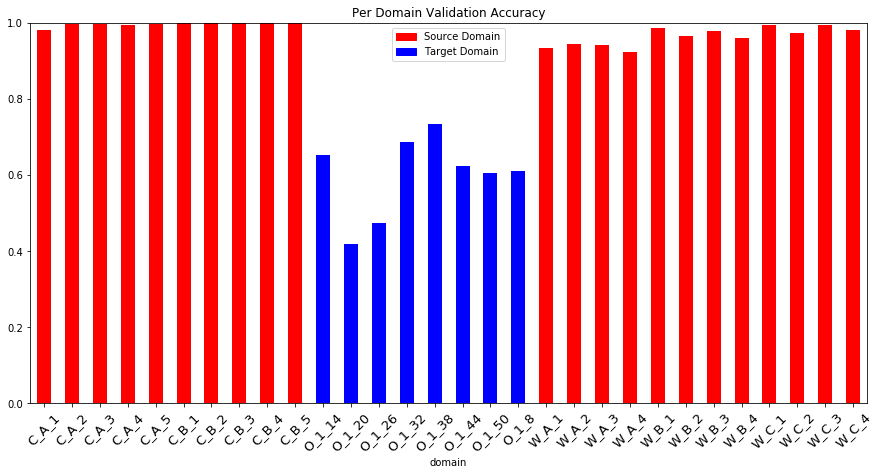

In [21]:
get_domain_accuracies(experiment)

In [22]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9814936775553214 Target Test Label Accuracy: 0.6050739247311828
Source Val Label Accuracy: 0.9813948893572181 Target Val Label Accuracy: 0.6010752688172043


In [23]:
json.dumps(experiment)

'{"experiment_name": "STANDALONE PTN", "parameters": {"experiment_name": "STANDALONE PTN", "lr": 1e-05, "device": "cuda", "seed": 1337, "dataset_seed": 1337, "n_way": 8, "n_shot": 3, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "n_epoch": 100, "patience": 10, "criteria_for_best": "target_accuracy", "datasets": [{"labels": ["2-18.", "11-17.", "1-18.", "8-18.", "2-7.", "4-11.", "13-20.", "3-3.", "14-10.", "1-19.", "11-14.", "1-15.", "2-3.", "2-8.", "1-10.", "17-2.", "11-7.", "7-10.", "17-10.", "1-16.", "1-17.", "4-19.", "2-17.", "4-10.", "10-4.", "19-16.", "2-10.", "19-3.", "2-20.", "16-1.", "2-5.", "3-18.", "19-20.", "14-14.", "1-11.", "11-20.", "8-8.", "2-4.", "14-11.", "2-11."], "domains": [1, 2, 3, 4, 5], "num_examples_per_domain_per_label": 100, "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl", "source_or_target_dataset": "source", "x_transforms": ["jitter_256_10", "lowpass_+/-10MHz", "take_200"], "episode_transform